<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

 # [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a>:  Traitements élémentaires des variables "métier"
** Résumé **
Ce cas d'usage de reconnaissance d'activités humaines à partir des enregistrements d'un smartphone (gyroscope, accéléromètre) est traité pour illustrer les principales étapes d'exploration et apprentissage communes en *science des données*. Exploration multidimensionnelle par méthodes factorielles, classification non supervisée, avant d'aborder le problème de classification non supervisée pour prévoir l'activité. Plusieurs méthodes sont apprises sur l'échantillon d'apprentissage, certaines, optimisées par validation croisée, puis leurs performances comparées sur la qualité de prévision de l'échantillon test.

#  Introduction
## Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone. Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)](). Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

Elle contient également deux fichiers "train" et "test" de *features* ou variables métier calculées dans les domaines temporels et fréquentiels: 561 variables.

Les données sont labellisées avec 6 activités: debout, assis, couché, marche, monter ou descendre un escalier. Il s'agit donc d'un problème de classification supervisée (6 classes) avec 10299 observations pour l'apprentissage, 2947 pour le test, décrites par 561 variables.

Voici une liste indicative des variables calculées sur chacune des variables initiales et couples de variables:

Name|Signification
-|-
mean | Mean value
std | Standard deviation
mad | Median absolute value
max | Largest values in array
min | Smallest value in array
sma | Signal magnitude area
energy | Average sum of the squares
iqr | Interquartile range
entropy | Signal Entropy
arCoeff | Autorregresion coefficients
correlation | Correlation coefficient
maxFreqInd | Largest frequency component
meanFreq | Frequency signal weighted average
skewness | Frequency signal Skewness
kurtosis | Frequency signal Kurtosis
energyBand | Energy of a frequency interval
angle | Angle between two vectors

##  Objectifs
Cette *première étape* s'intéresse aux seules variables construites à partir des connaissances *a priori* du comportement des capteurs en fonction des types d'activité humaine. Ce premier calepin propose une exploration et une modélisation, des 561 variables métier. Il s'agit de répondre à la question: quel algorithme d'apprentissage permet de déterminer au mieux l'activité humaine? 

Une *deuxième étape*  s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant, par exemple, des décompositions systématiques sur une base d'ondelettes ou mieux un algorihtme d'apprentissage profond sur les seules données brutes? L'enjeu est d'obtenir une discrimination sur les données brutes donc moins énergivores qu'un calcul préalable des caractéristiques métier.

In [1]:
# Importation des principals librairies et 
# Affichage des graphiques dans le notebook
import numpy as np
import pandas as pd
import time
import utils.load as ul

# Plot and display
import utils.illustration as uil
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

In [2]:
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}
COLOR_DIC = {v:CMAP(k-2) if v!="WALKING" else CMAP(11) for k,v in ACTIVITY_DIC.items()}
LABELS = [ACTIVITY_DIC[c] for c in range(1,7)]
COLOR_LIST = [COLOR_DIC[l] for l in LABELS]

#  Lecture des données

Les données peuvent être préalablement téléchargées ou directement lues. Ce sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). 

In [3]:
# Lecture des données d'apprentissage
# Attention, il peut y avoir plusieurs espaces comme séparateur dans le fichier
Xtrain=ul.my_read_csv("train/X_train.txt")
N_train = Xtrain.shape[0]
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [4]:
# Variable cible
ytrain=ul.my_read_csv("train/y_train.txt")
# Le type dataFrame est inutile et même gênant pour les la suite
ytrain = ytrain[0]
ytrain_label = np.array([ACTIVITY_DIC[y] for y in ytrain])

In [5]:
# Lecture des données de test
Xtest=ul.my_read_csv("test/X_test.txt")
Xtest.shape

(2947, 561)

In [6]:
ytest=ul.my_read_csv("test/y_test.txt")
ytest=ytest[0]
ytest_label = np.array([ACTIVITY_DIC[y] for y in ytest])

#  Exploration
## [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
### Principe
Il est important de se faire une idée précise de la structure des données.  Une analyse en composantes principales est adaptée à cet objectif. 

   - Elle recherche les axes de plus grande dispersion du nuages des individus dans $R^p$ avec $p=561$. Ces axes sont définis par les vecteurs propres de la matrice des covariances ou des corrélations si les variables sont réduites (divisées par l'écart-type).
   - Les représentations graphiques des individus sont obtenues par projection sur les sous-espaces engendrés par les premiers vecteurs propres. Elles préservent au mieux les distances entre ceux-ci.
   - Les coordonnées sont stockées dans la matrice des *composantes principales* qui sont aussi les combinaisons linéaires de plus grande variance des variables. Ce sont des variables décorrélées, orthogonales deux à deux.
   - Les representations graphiques des variables initiales conservent au mieux les angles entre les vecteurs variables dans l'espace $R^n$ de façon à interpréter leurs corrélations qui, géométriquement, sont les cosinus de ces angles. 

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

Calcul de la matrice des composantes principales. C'est aussi un changement (transformation) de base; de la base canonique dans la base des vecteurs propres. 

In [8]:
pca = PCA()
X_r = pca.fit_transform(Xtrain)

### Valeurs propres ou variances des composantes principales
Représentation de la décroissance des valeurs propres, les variances des variables ou composantes principales (à gauche) et un graphique plus explicite décrit les distributions de ces composantes par des diagrammes boîtes; seules les premières sont affichées (à droite).

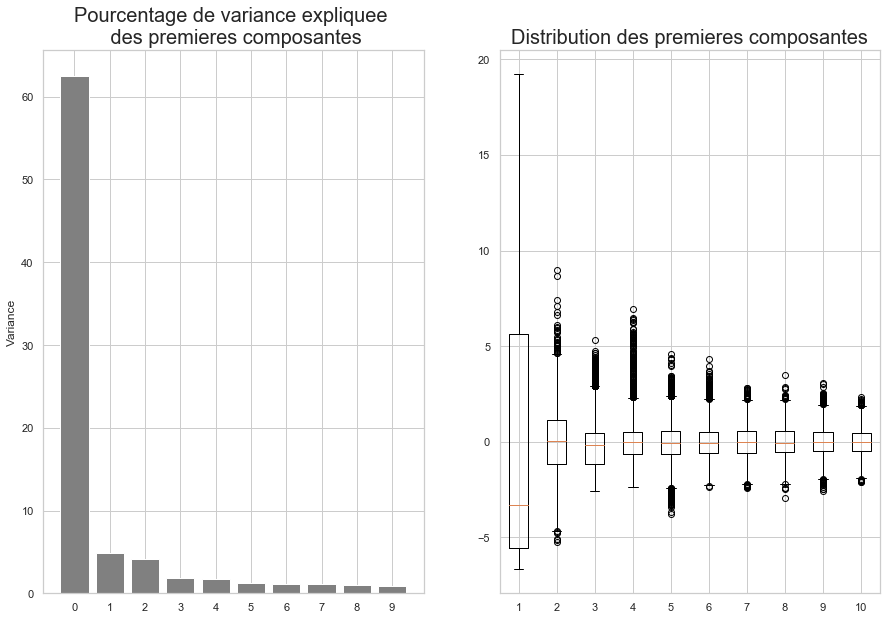

In [9]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_r)

Commenter la décroissance des variances, le choix éventuel d'une dimension ou nombre de composantes à retenir sur les 561.
### Représentation des individus
Projection dans les principaux plans factoriels.
La fonction définie ci-après affiche un nuage de points dans un plan factoriel.

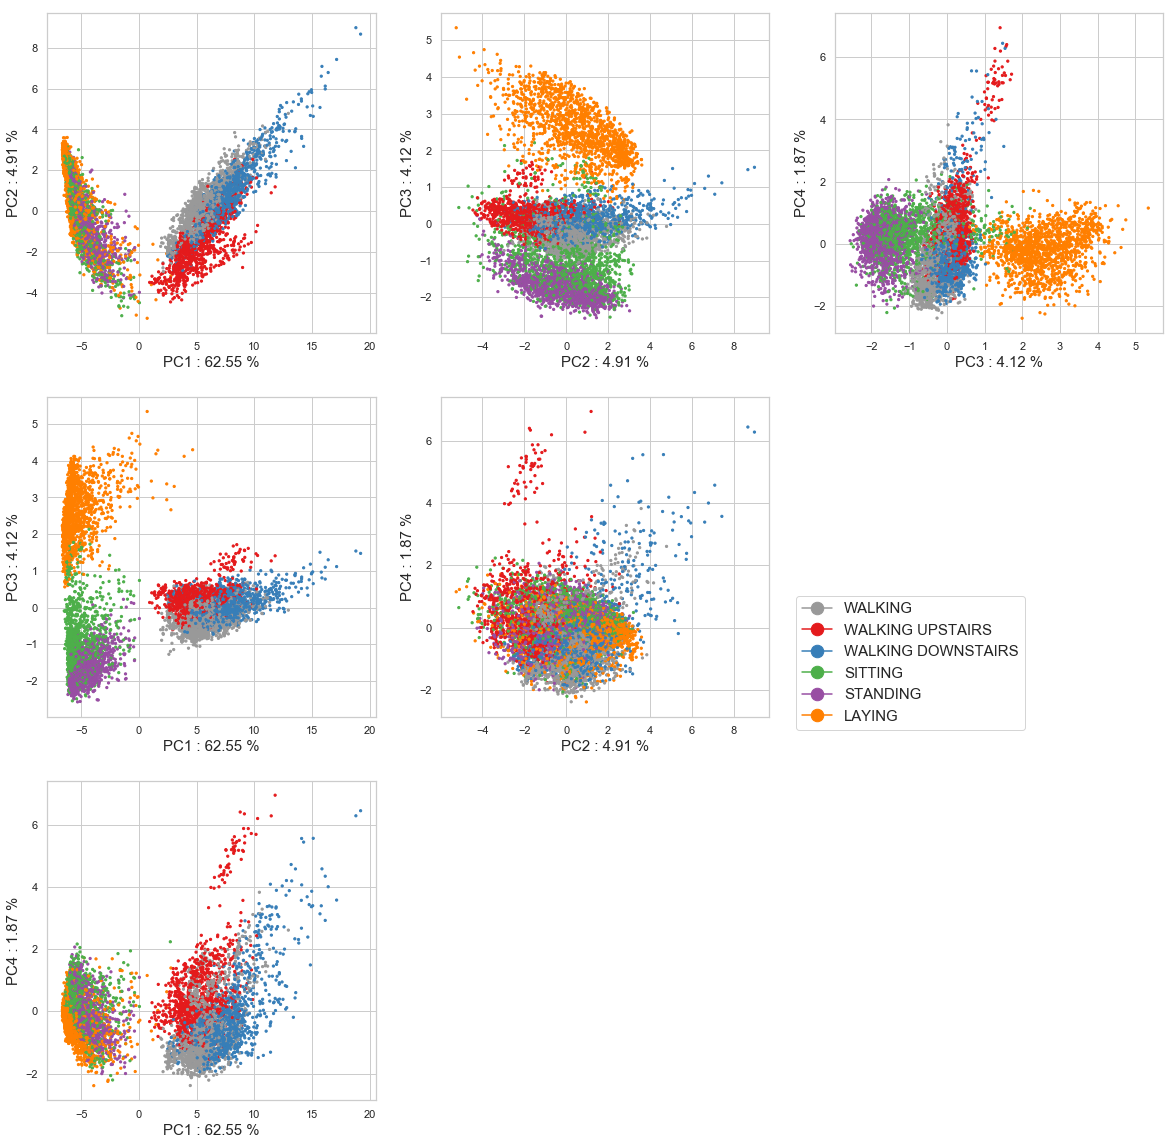

In [10]:
colors=[COLOR_DIC[y] for y in ytrain_label]
markersizes = [20 for y in ytrain]

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax, X_r, pca, nbc, nbc2, colors, markersizes)

#Build legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=COLOR_DIC[act],marker=".", linestyle=None, markersize=25, label=act)for act in ACTIVITY_DIC.values()]
plt.legend(handles=legend_elements,loc='upper right', bbox_to_anchor=(3, 1.6),fontsize=15)
plt.show()

**Q** Commenter la séparation des deux types de situation par le premier axe.

**Q** Que dire sur la forme des nuages?

**Q** Que dire sur la plus ou moins bonne séparation des classes?

### Représentation des variables
Lecture des libellés des variables et constitution d'une liste. Souci de la grande dimension (561), les représentations ne sont guère exploitables. 

In [11]:
with open('features.txt', 'r') as content_file:
    featuresNames = content_file.read()
columnsNames = list(map(lambda x : x.split(" ")[1],featuresNames.split("\n")[:-1]))

Graphe illisible en mettant les libellés en clair. Seule une * est représentée.

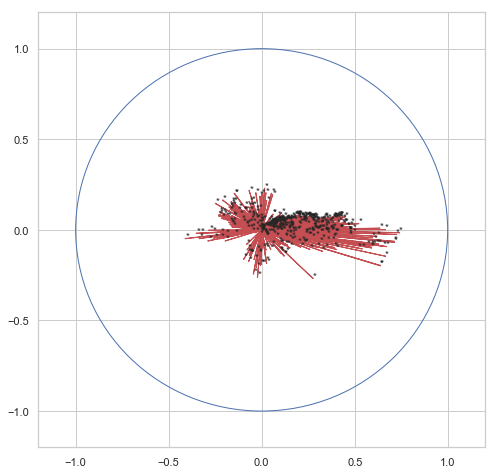

In [12]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j in zip(coord1,coord2, ):
    plt.text(i, j, "*")
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

Identification des variables participant le plus au premier axe. Ce n'est pas plus clair! Seule la réprésentation des individus apporte finalement des éléments de compréhension.

In [13]:
np.array(columnsNames)[abs(coord1)>.6]

array(['tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Y',
       'tBodyAccMag-entropy()', 'tGravityAccMag-entropy()',
       'tBodyAccJerkMag-entropy()', 'tBodyGyroJerkMag-entropy()',
       'fBodyAcc-entropy()-X', 'fBodyAcc-entropy()-Y',
       'fBodyAcc-entropy()-Z', 'fBodyAccJerk-entropy()-X',
       'fBodyAccJerk-entropy()-Y', 'fBodyAccJerk-entropy()-Z',
       'fBodyAccMag-entropy()', 'fBodyBodyAccJerkMag-entropy()',
       'fBodyBodyGyroJerkMag-entropy()'], dtype='<U36')

## [Analyse Factorielle Discriminante (AFD)](http://wikistat.fr/pdf/st-m-explo-afd.pdf)
### Principe
L'ACP ne prend pas en compte la présence de la variable qualitative à modéliser contrairement à l'analyse factorielle discriminante qui calcule l'ACP des barycentres des classes. De plus, l'espace des individus est muni d'une métrique spécifique: *Mahalanobis*. L'objectif est alors de visualiser les capacités des variables à discriminer les classes.

La librairie `scikit-learn` ne propose pas de fonction spécifique d'analyse factorielle discriminante mais les coordonnées des individus dans la base des vecteurs discriminants sont obtenues comme résultats de l'analyse discriminante linéaire décisionnnelle. Cette dernière sera utilisée avec une finalité prédictive dans un deuxième temps.

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
method = LinearDiscriminantAnalysis() 
lda=method.fit(Xtrain,ytrain)
X_r2=lda.transform(Xtrain)

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Représentation des individus

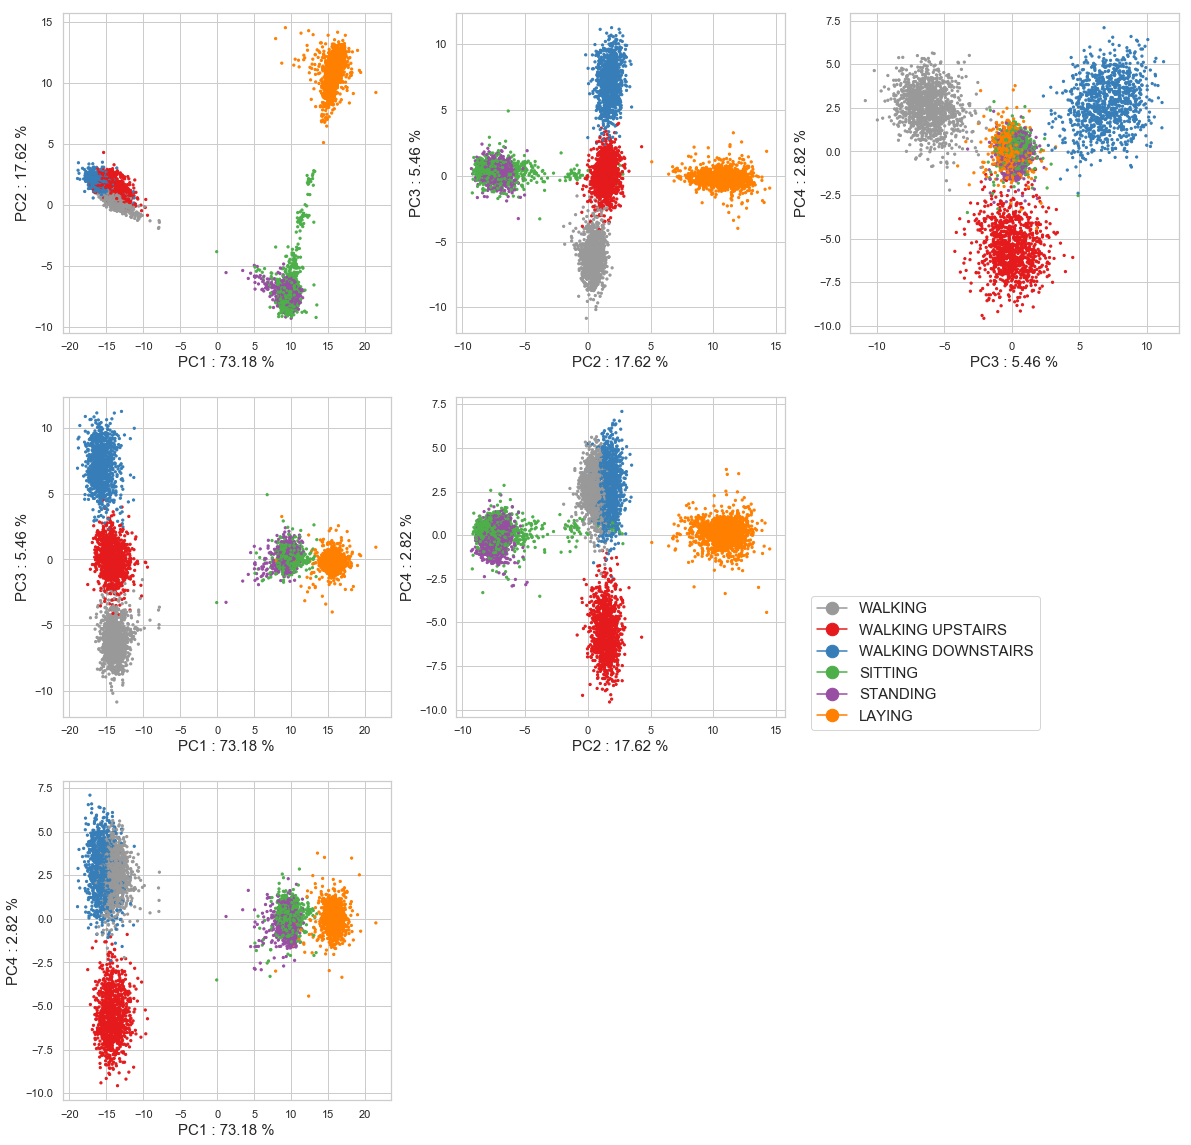

In [15]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax, X_r2, lda, nbc, nbc2, colors, markersizes)
#Build legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=COLOR_DIC[act],marker=".", linestyle=None, markersize=25, label=act)for act in ACTIVITY_DIC.values()]
plt.legend(handles=legend_elements,loc='upper right', bbox_to_anchor=(3, 1.6),fontsize=15)
plt.show()

**Q** Que dire de la séparation des classes. Sont-elles toutes séparables deux à deux?

**Q** Que dire de la forme des nuages notamment dans le premier plan?

Comme pour l'ACP, la représentation des variables n'apporte rien.

##  Classification non supervisée avec $k$*-means*
Cette section n'est pas utile, puisque les classes sont connues, mais elle permet d'illustrer le comportement d'un algorithme de classification non supervisée. Comparer dans une matrice de confusion les classes obtenues avec celles connues permet d'en apprécier les performances. L'algorithme DBSCAN a été testé mais ne fournit pas de résultats pertinents.

*Attention*, il est nécessaire de centrer et réduire les variables avant d'exécuter un algorithme de classification non supervisée.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
tps1 = time.clock()
X = StandardScaler().fit_transform(Xtrain)
km=KMeans(n_clusters=6, n_jobs=-1)
km.fit(Xtrain)
tps2 = time.clock()
print("Temps execution Kmeans :", (tps2 - tps1))

/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Temps execution Kmeans : 14.678594000000002


/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [17]:
pd.DataFrame(confusion_matrix(km.labels_, ytrain)[:-1,1:], columns=LABELS)

,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
0,591,807,134,1,0,10
1,0,0,0,924,947,0
2,550,217,625,0,0,0
3,0,0,0,50,0,1239
4,85,49,227,0,0,0
5,0,0,0,311,427,158


#  Apprentissage et prévision de l'échantillon test
Un échantillon test est fourni avec les données. Cet échantillon est utilisé pour estimer une erreur de prévision comparable avec celles de la littérature. Néanmoins, il serait opportun de d'exécuter une validation croisée *Monte Carlo*. Certes l'échantillon test est de taille raisonnable (2947) mais comme les prévisions sont très bonnes, les comparaisons ne reposent que sur le plus ou moins bon classement de quelques situations parmi les 2947.

Différentes méthodes sont successivement testées.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

##  [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)
### Principe
Une méthode ancienne mais finalement efficace sur ces données. La régression logistique est adaptée à la prévision d'une variable binaire. Dans le cas multiclasse, la fonction logistique de la librairie `Scikit-learn` estime par défaut un modèle par classe, cette classe contre les autres. 

La probabilité d'appartenance d'un individu à une classe est modélisée à l'aide d'une combinaison linéaire des variables explicatives. Pour transformer une combinaison linéaire à valeur dans $R$ en une probabilité à valeurs dans l'intervalle $[0, 1]$, une fonction de forme sigmoïdale, inverse de la fonction *logit*, est appliquée.  Ceci donne: $P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$ ou encore, $\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb$


### Estimation et erreur sans optimisation

In [19]:
ts = time.time()
method = LogisticRegression()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [20]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.961995, time running : 4 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,432,55,0,0,4
STANDING,0,13,517,2,0,0
WALKING,0,0,0,494,2,0
WALKING DOWNSTAIRS,0,0,0,4,407,9
WALKING UPSTAIRS,0,0,0,23,0,448


Commenter la qualité des résultats obtenus. Sont-ils cohérents avec l'approche exploratoire ?

### Sélection de variables par pénalisation Lasso
Le paramètre de pénalisation est optimisé par* $V$-fold* validation croisée. Noter la pertinence de cette librairie qui peut, même sous *windows* utiliser tous les coeurs de la machine.

**Q** Que vaut $V$?. 

*Attention* C'est un peu long!

In [21]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
ts = time.time()
param=[{"C":[3, 4, 5]}]
logit = GridSearchCV(LogisticRegression(penalty="l1"), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(Xtrain, ytrain)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Temps : 70 secondes


In [22]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.953346, Meilleur paramètre = {'C': 3}


In [23]:
yChap = logitOpt.predict(Xtest)
yChap_label = np.array([ACTIVITY_DIC[y] for y in yChap])
# matrice de confusion
logitOpt.score(Xtest, ytest)

0.9630132337970818

In [24]:
pd.crosstab(ytest_label, yChap_label, rownames=['True'], colnames=['Pred'])

Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,426,60,0,0,5
STANDING,0,10,520,2,0,0
WALKING,0,0,0,493,1,2
WALKING DOWNSTAIRS,0,0,0,4,411,5
WALKING UPSTAIRS,0,0,0,20,0,451


**Q** L'amélioration est-elle bien significative?

##  [Analyse discriminante linéaire](http://wikistat.fr/pdf/st-m-app-add.pdf)
### Principe
Cette méthode, également ancienne, est principalement due à Fisher dans les années trente. La règle d'affectation d'un nouvel individu à une classe est basée sur la *distance de Mahalanobis*. Cette distance est définie par la matrice inverse de la matrice de covariance intra-classe. Un individu est affecté à la classe dont le barycentre est le plus proche au sens de cette métrique. L'inversion de la matrice pose des problèmes si les variables explicatives sont colinéaires ou presque. L'algorithme utilisé par défaut dans `Scikit-learn` (SVD) le contourne et fournit un avertissement mais des résultats. 

Implicitement, cette méthode suppose que les variables sont gaussiennes multidimensionnelles ainsi qu'une hypothèse d'homoscédasticité: les classes partagent la même structure (matrice) de covariance. Sans hypothèse d'homoscédasticité, une matrice de covariance devrait être estimée pour chaque classe. Il s'agit alors d'une analyse discriminante quadratique. Les problèmes de multicolinéarité empêchent l'utilisation de cette approche. il faudrait procéder à une sélection préalable des données ou éventuellement la calculer sur les premières composantes principales de l'ACP afin d'éviter les problèmes de conditionnement des matrices.

In [25]:
ts = time.time()
method = LinearDiscriminantAnalysis()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [26]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.962335, time running : 0 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,434,56,0,0,1
STANDING,0,22,510,0,0,0
WALKING,0,0,0,490,0,6
WALKING DOWNSTAIRS,0,0,0,1,405,14
WALKING UPSTAIRS,0,0,0,11,0,460


**Q** Comparer avec les résultats obtenus avec la régression logistique.

##  [*K* plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)
Le problème de discrimination semble assez simple. Les méthodes linéaires conduisent à de bons résultats mais ce n'est pas nécessairement le cas pour toutes les méthodes. 
### Principe

L'algorithme des *K* plus proches voisins peut être présenté comme un cas particulier d'analyse discriminante avec une estimation locale des fonctions de densité conditionnelle à chaque classe. Le principe en est simple. Pour affecter un nouvel individu à une classe, il suffit d'dentifier les $k$ plus proches voisins au sens d'une distance à préciser puis, cet individu est affecté à la classe la plus représentée parmi les $k$ voisins; $k$ peut être optimisé par validation croisée.

**Q** Rechercher dans la documentation, la valeur par défaut de $k$; ainsi que celle de la métrique. 

In [27]:
ts = time.time()
method = KNeighborsClassifier(n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()
t_total = te-ts

In [28]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.901595, time running : 4 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,534,2,1,0,0,0
SITTING,0,389,99,0,0,3
STANDING,0,37,495,0,0,0
WALKING,0,0,0,485,9,2
WALKING DOWNSTAIRS,0,0,0,45,330,45
WALKING UPSTAIRS,0,0,0,40,7,424


**Q** Les résultats obtenus méritent-ils de lancer une optimisation de $k$?

##  [*Random forest*](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

Algorithme breaucoup plus sophistiqué principalement dû à Léo Breiman (2001); il est basé sur l'agrégation d'arbres binaires de décision, régression ou classification, selon le type de la variable cible $y$. L'algorithme consiste à tirer `n_estimators` échantillons bootstrap. Comme dans le *bagging*, un arbre est estimé pour chaque échantillon bootstrap et la prévision est obtenue par moyenne (régression) ou vote majoritaire (classification) des prévisions individuelles de chaque arbre. Pour construire les arbres moins corrélés et rendre l'agrégation plus efficace, Breiman à ajouté au *bagging* une perturbation aléatoire. Lors de la construction de chaque noeud de chaque arbre, la division optimale est recherchée sur un sous-ensemble aléatoire des variables, de cardinal `max_valeur`. 

Cette méthode, très efficace pour résoudre des problèmes non linéaires apparaît moins performante lorsque les frontières des classes semblent assez linéaires. Son investigation (optimisation de `max_valeur`) ainsi que l'utilisation des algorithmes de principe similaire (*boosting*) ne sont pas approfondies. 

In [29]:
ts = time.time()
method = RandomForestClassifier(n_estimators=200,n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()
t_total = te-ts

In [30]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.929080, time running : 3 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,440,51,0,0,0
STANDING,0,43,489,0,0,0
WALKING,0,0,0,482,9,5
WALKING DOWNSTAIRS,0,0,0,18,361,41
WALKING UPSTAIRS,0,0,0,36,6,429


##  [*SVM*](http://wikistat.fr/pdf/st-m-app-svm.pdf)
### Principe
La recherche de séparateurs à *vaste marge* est en principe adaptée à la discrimination de deux classes. Comme pour la régression logistique et par défaut, le cas multiclasse se traite en cherchant un hyperplan séparateur pour chaque classe contre les autres. Difficile de résumer en quelques lignes le principe de cet algorithme basé sur une optimisation quadratique de la *marge* d'un hyperplan séparateur sous contraintes que les individus soient bien situés de part et d'autre de l'hyperplan. L'astuce du noyau, souvent gaussien, permet de rendre linéaire des problèmes qui ne le sont pas. Dans le cas présent, la version linéaire conduit à de bons résulats alors que l'utilisation du noyau gaussien ne les améliore pas, même après un effort d'optimisation des paramètres de pénalisation et de régularité du noyau.
### *SVM* linéaire

In [31]:
ts = time.time()
method = LinearSVC()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()
t_total = te-ts

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.965728, time running : 3 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,2,426,59,0,0,4
STANDING,0,10,521,1,0,0
WALKING,0,0,0,496,0,0
WALKING DOWNSTAIRS,0,0,0,2,413,5
WALKING UPSTAIRS,0,0,0,17,1,453


### *SVM* avec noyau gaussien
Apprentissage avec les valeurs par défaut puis optimisation des paramètres par validation croisée.

**Q** Que sont ces paramètres?

In [33]:
ts = time.time()
method = SVC()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [34]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.crosstab(ytest_label, ypred_label, rownames=['True'], colnames=['Pred'])

Score : 0.940278, time running : 18 secondes


Pred,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,424,65,0,0,2
STANDING,0,44,488,0,0,0
WALKING,0,0,0,492,4,0
WALKING DOWNSTAIRS,0,0,0,13,378,29
WALKING UPSTAIRS,0,0,0,17,2,452


In [35]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xtrain, ytrain)
te = time.time()
te-ts

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process

252.55297780036926

In [36]:
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.957427, Meilleur paramètre = {'C': 5, 'gamma': 0.02}


**Q** Comparer les deux approches par SVM (linéaire et radiale): temps de calcul et performance.

## Représentations graphiques

/anaconda3/envs/DL/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


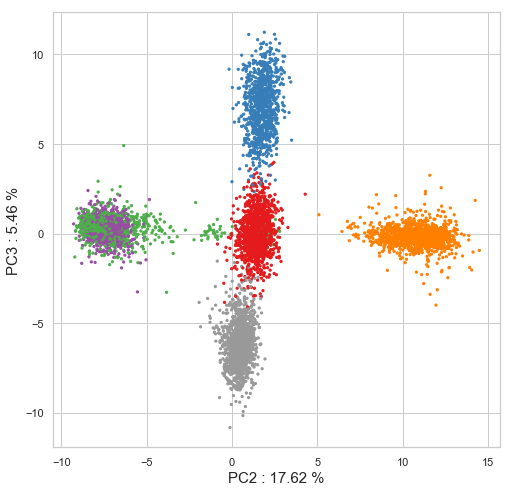

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
method = LinearDiscriminantAnalysis() 
lda=method.fit(Xtrain,ytrain)
X_r2=lda.transform(Xtrain)

fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)
uil.plot_pca(ax, X_r2, lda, 2, 3, colors, markersizes)

In [38]:
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def make_contour(fig, ax, X, colors, colors_list, title, markers):

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1) 

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, colors=colors_list, alpha=0.8)
    
    #for x0, x1, m, c in zip(X0,X1, markers, colors):
    #    ax.plot(x0, x1, marker=m, color=c, markeredgecolor="k")
    ax.scatter(X0, X1 , c=colors, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

    plt.show()





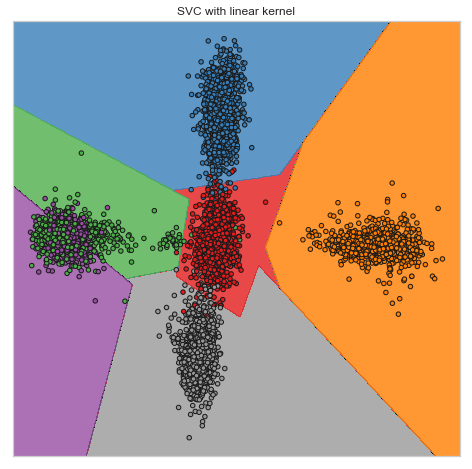

In [40]:
# Take the first two features. We could avoid this by using a two-dim dataset
X = X_r2[:,1:3]
y = ytrain

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
model = svm.SVC(kernel='linear', C=C)
model = model.fit(X, y)


markers = ["X" if i in model.support_ else "." for i in range(N_train)]
# Set-up 2x2 grid for plotting.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

make_contour(fig, ax, X, colors, colors_list = COLOR_LIST[:4]+["black"]+COLOR_LIST[4:], 
             title = 'SVC with linear kernel', markers=markers)


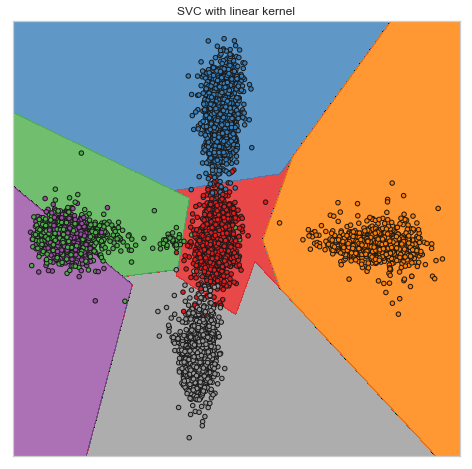

In [42]:
# Take the first two features. We could avoid this by using a two-dim dataset
X = X_r2[:,1:3]
y = ytrain

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 10  # SVM regularization parameter
model = svm.SVC(kernel='linear', C=C)
model = model.fit(X, y)

# Set-up 2x2 grid for plotting.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

make_contour(fig, ax, X, colors, colors_list = COLOR_LIST[:4]+["black"]+COLOR_LIST[4:], title = 'SVC with linear kernel', markers=markers)



In [ ]:
# Take the first two features. We could avoid this by using a two-dim dataset
X = X_r2[:,1:3]
y = ytrain

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model = model.fit(X, y)

# Set-up 2x2 grid for plotting.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

make_contour(fig, ax, X, colors, colors_list = COLOR_LIST[:4]+["black"]+COLOR_LIST[4:], title = 'SVC with linear kernel', markers=markers)


# Conclusion

En résumé, les méthodes linéaires conduisent à de bons résultats regroupés dans un mouchoir. Beaucoup d'autres algorithmes n'ont pas été testés; notamment les réseaux de neurones, la régression PLS, le boosting...  Mais, comme les méthodes non linéaires ne semblent pas pertinentes, rechercher des combinaisons de méthodes linéaires pourraient être payant.

Les formes des nuages de chaque classe observées dans le premier plan de l'analyse en composantes principales montrent que la structure de covariance n'est pas identique dans chaque classe. Cette remarque suggèrerait de s'intéresser à l'analyse discriminante quadratique mais celle-ci bloque sur l'estimation six matrices de covariance et de leurs inverses. Néanmoins il semble que, plus précisément, deux groupes se distinguent: les classes actives (marcher, monter ou descendre un escalier) d'une part et les classes passives (couché, assis, debout) d'autre part et, qu'à l'intérieur de chaque groupe les variances sont assez similaires. 

Cette situation suggère de construire une décision en deux étapes ou hiérarchique:
1. Régression logistique prévoyant l'activité passive *vs.* active,
2. Analyse discriminante linéaire spécifique à chacun de ces deux cas.

Dans le même ordre idée, il est facile de remarquer que les deux classes difficiles à séparer sont "assis" et "debout". Il peut être utile de se focaliser sur cette question afin d'identifier le meilleur classifieur à intégrer dans la hiérarchie.

Il serait fastidieux de tout vouloir tester, l'objectif n'est pas ici de se classer dans un concours *kaggle* mais de simplement illustrer les usages de quelques algorihtmes d'apprentissage. 

Se souvenir que l'objectif principal est focalisé le choix de la méthode selon les caractéristiques des données. Même si les méthodes linéaires donnent de bons résultats au contraire de celles plus sophistiquées, il faut se garder de généraliser. Pour s'en convaincre, il suffit de s'intéresser aux problèmes de la [reconnaissance de caractères]().